# 📰 Keyword-Based News Classification

Classify news articles into four categories using only the most frequent words from their short descriptions.

---

## 📚 Categories
- <span style="color:#d7263d;"><b>POLITICS</b></span>
- <span style="color:#1b98e0;"><b>TRAVEL</b></span>
- <span style="color:#28a745;"><b>SPORTS</b></span>
- <span style="color:#f9a602;"><b>HOME & LIVING</b></span>

---

## 🚀 Workflow Overview

1. <span style="color:#7c3aed;"><b>Data Preprocessing</b></span>  
   Clean and balance the dataset for the selected categories.

2. <span style="color:#f46036;"><b>Exploratory Analysis & Word Clouds</b></span>  
   Visualize the most frequent words per category.

3. <span style="color:#43bccd;"><b>Keyword-Based Classification</b></span>  
   Assign categories based on overlap with category-specific frequent words.

4. <span style="color:#ff6f61;"><b>Experimentation</b></span>  
   Evaluate performance with varying numbers of frequent words.

5. <span style="color:#4f8a8b;"><b>Results & Reporting</b></span>  
   Visualize accuracy trends and analyze per-category performance.

In [3]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
import random

RANDOM_SEED = 42

In [4]:
# 2. Load and Prepare Dataset
# Download the dataset from Kaggle
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

# Keep only needed columns and categories
categories = ['POLITICS', 'TRAVEL', 'SPORTS', 'HOME & LIVING']
df = df[df['category'].isin(categories)][['short_description', 'category']]

# Drop rows with missing short_description
df = df.dropna(subset=['short_description'])

# Balance dataset: 1000 samples per category
balanced_df = df.groupby('category').apply(lambda x: x.sample(1000, random_state=RANDOM_SEED)).reset_index(drop=True)
print(balanced_df['category'].value_counts())

category
HOME & LIVING    1000
POLITICS         1000
SPORTS           1000
TRAVEL           1000
Name: count, dtype: int64


C:\Users\bbuser\AppData\Local\Temp\ipykernel_3384\3662364254.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('category').apply(lambda x: x.sample(1000, random_state=RANDOM_SEED)).reset_index(drop=True)


In [5]:
# 3. Train/Test Split (Stratified 80/20)
train_df, test_df = train_test_split(
    balanced_df, 
    test_size=0.2, 
    stratify=balanced_df['category'], 
    random_state=RANDOM_SEED
)
print('Train:', train_df.shape, 'Test:', test_df.shape)

Train: (3200, 2) Test: (800, 2)


In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bbuser\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [8]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

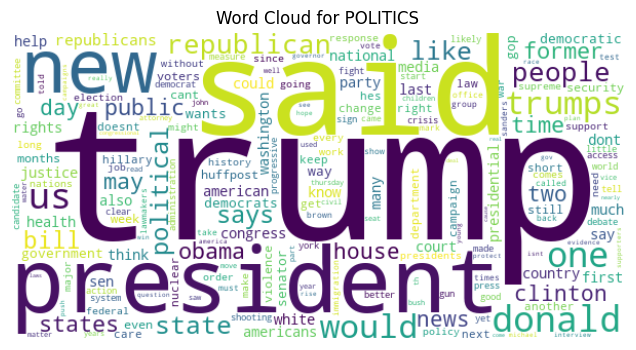

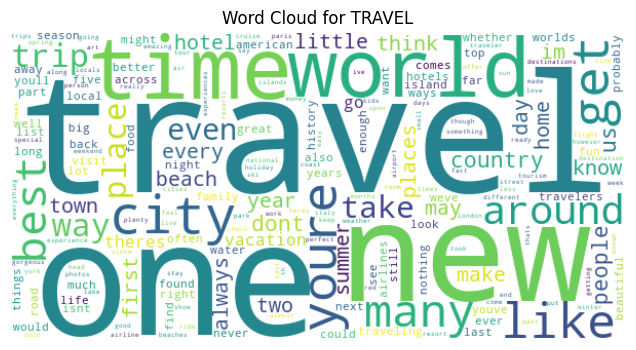

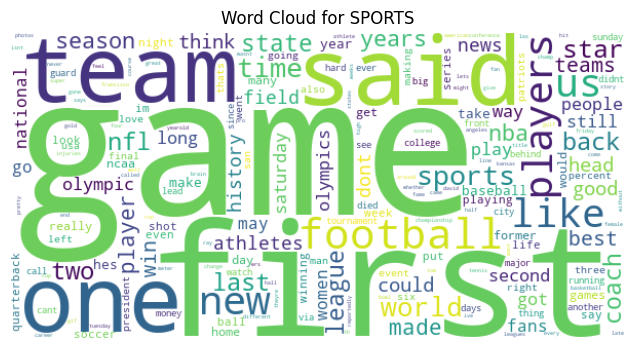

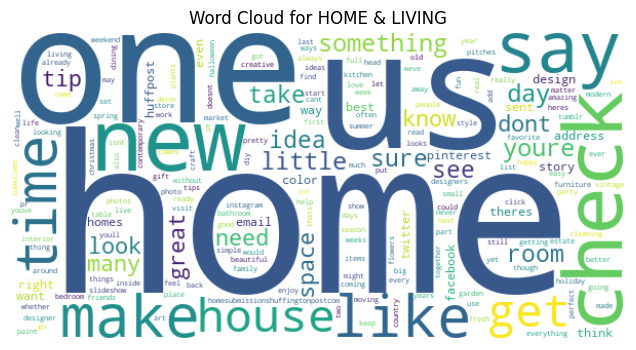

Top 10 words for POLITICS: ['trump', 'said', 'president', 'new', 'donald', 'us', 'one', 'would', 'trumps', 'republican']
Top 10 words for TRAVEL: ['travel', 'one', 'new', 'time', 'world', 'city', 'get', 'youre', 'like', 'many']
Top 10 words for SPORTS: ['game', 'first', 'said', 'team', 'one', 'football', 'players', 'new', 'us', 'like']
Top 10 words for HOME & LIVING: ['home', 'us', 'one', 'new', 'check', 'say', 'make', 'time', 'like', 'house']


In [9]:
# 4. Word Clouds and Frequent Words
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return words

category_word_counts = {}
category_wordclouds = {}
top_words_per_category = {}

for cat in categories:
    texts = train_df[train_df['category'] == cat]['short_description']
    all_words = []
    for desc in texts:
        all_words += clean_text(desc)
    counter = Counter(all_words)
    category_word_counts[cat] = counter
    # Generate and show wordcloud
    wc = WordCloud(width=600, height=300, background_color='white').generate_from_frequencies(counter)
    category_wordclouds[cat] = wc
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {cat}')
    plt.show()
    # Save top words
    top_words_per_category[cat] = [w for w, c in counter.most_common(100)]

# Show top 10 frequent words for each category
for cat in categories:
    print(f"Top 10 words for {cat}: {top_words_per_category[cat][:10]}")


In [10]:
# 5. Keyword-based Classification Function
def classify_keywords(desc, word_sets):
    words = set(clean_text(desc))
    overlaps = {cat: len(words & set(word_sets[cat])) for cat in categories}
    max_overlap = max(overlaps.values())
    if list(overlaps.values()).count(max_overlap) > 1:
        # Tie: assign 'unknown' or choose random among tied
        tied = [cat for cat, v in overlaps.items() if v == max_overlap]
        return random.choice(tied)
    else:
        return max(overlaps, key=overlaps.get)

In [11]:
# 6. Experiment: Varying Top-N Words
results = []
Ns = [10, 20, 30, 50, 70, 100]

for N in Ns:
    word_sets = {cat: set(top_words_per_category[cat][:N]) for cat in categories}
    preds = test_df['short_description'].apply(lambda x: classify_keywords(x, word_sets))
    acc = np.mean(preds == test_df['category'])
    results.append((N, acc))
    print(f"Top {N} words: Accuracy = {acc:.3f}")
    
# Detailed analysis per category
    
    if N == max(Ns):
        test_df['pred'] = preds
        print('\nClassification report (Top 100 words):')
        print(pd.crosstab(test_df['category'], test_df['pred'], rownames=['True'], colnames=['Predicted']))


Top 10 words: Accuracy = 0.374
Top 20 words: Accuracy = 0.431
Top 30 words: Accuracy = 0.469
Top 50 words: Accuracy = 0.465
Top 70 words: Accuracy = 0.481
Top 100 words: Accuracy = 0.507

Classification report (Top 100 words):
Predicted      HOME & LIVING  POLITICS  SPORTS  TRAVEL
True                                                  
HOME & LIVING             94        22      31      53
POLITICS                  25       110      33      32
SPORTS                    35        25      89      51
TRAVEL                    40        21      26     113


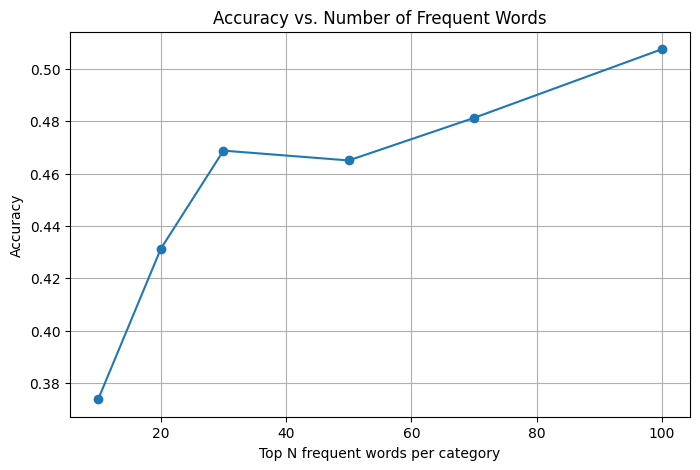

In [12]:
# 7. Plot Accuracy vs. Number of Frequent Words
plt.figure(figsize=(8,5))
plt.plot([n for n, _ in results], [acc for _, acc in results], marker='o')
plt.title('Accuracy vs. Number of Frequent Words')
plt.xlabel('Top N frequent words per category')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

###  Analyze Per-Category Performance

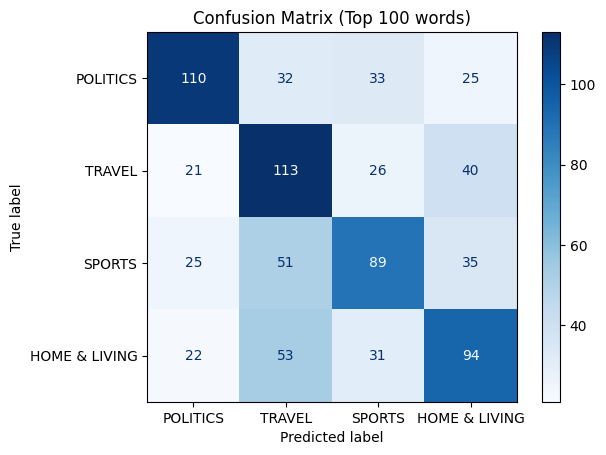

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming test_df['category'] contains true labels, test_df['pred'] contains predictions
cm = confusion_matrix(test_df['category'], test_df['pred'], labels=categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix (Top {max(Ns)} words)')
plt.show()

### Summary Table

In [15]:
for cat in categories:
    cat_mask = test_df['category'] == cat
    cat_acc = np.mean(test_df['pred'][cat_mask] == cat)
    print(f"Accuracy for {cat}: {cat_acc:.3f}")

Accuracy for POLITICS: 0.550
Accuracy for TRAVEL: 0.565
Accuracy for SPORTS: 0.445
Accuracy for HOME & LIVING: 0.470
